### Piecemeal Clustering
A clustering approach without prior knowledge about data even number of clusters. It uses similarity and density of data to define number of clusters. 

### Reading the Paper
#### Introduction
- No noise: KMeans, SOM
- Density-based: DBSCAN
- Precedents: trial and errors, combinations of multiple methods
- What is lithofaces, 
- The algorithm utilizes the density-based clustering combining the concepts of hierachical clustering, model-based unsupervised learning and density-based data clustering. 

### Reference:
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9980364

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.cluster import hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
X, y = datasets.load_iris(as_frame=True, return_X_y=True)

In [3]:
X = X.to_numpy()
y = y.to_numpy()
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [4]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Min scaled X: {np.min(X, axis=0)}")
print(f"Max scaled X: {np.max(X, axis=0)}")

Shape of X: (150, 4)
Shape of y: (150,)
Min scaled X: [0. 0. 0. 0.]
Max scaled X: [1. 1. 1. 1.]


Text(0.5, 1.0, 'Iris Flower (PCA)')

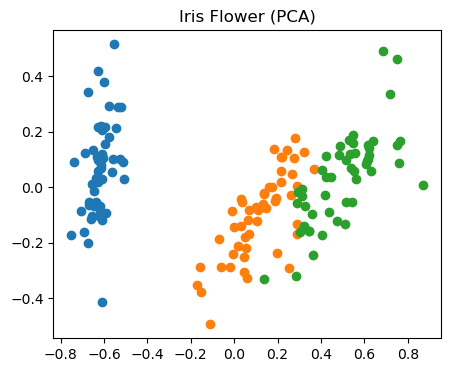

In [5]:
pca = PCA(n_components=2).fit(X)
X_r = pca.transform(X)
plt.figure(figsize=(5, 4))
for i in np.unique(y):
    t = X_r[y == i]
    plt.scatter(t[:,0], t[:,1])
plt.title("Iris Flower (PCA)")

### Pre Clustering

In [6]:
def merge_cluster(clusters, i, j, X = None):
    clusters = clusters.copy()
    for t in range(len(clusters)):
        if clusters[t] == j:
            clusters[t] = clusters[i]

    if X is not None:
        center = 0
        count = 0
        for t in range(len(clusters)):
            if clusters[t] == i:
                center += X[t]
                count += 1
        return clusters, center / count

    return clusters

In [7]:
def ind_to_pair(d, index):
    b = 1 - (2 * d) 
    i = (-b - np.sqrt(b ** 2 - 8 * index)) // 2
    j = index + i * (b + i + 2) // 2 + 1
    return (int(i), int(j))  

In [8]:
def compute_dist_threshold(dmatrix, cutoff: float):
    dmin = min(dmatrix)
    dmax = max(dmatrix)
    return (1 - (dmin / dmax)) * cutoff

def compute_sim_threshold(smatrix, cutoff: float, diff_factor: float):
    dmin = min(smatrix)
    dmax = max(smatrix)
    return (1 - (dmin / dmax)) * cutoff * diff_factor

In [17]:
def pairwise_cluster_distances(cluster_centers, diff_factor):
    dmatrix = sch.distance.pdist(X, metric="euclidean")
    smatrix = sch.distance.pdist(X, metric="cosine")
    dmax = max(dmatrix)
    smax = max(smatrix)

    dmatrix = dmatrix / dmax
    dmatrix = dmatrix ** 2
    
    smatrix = smatrix / smax
    smatrix = diff_factor * (smatrix ** 2)

    return np.sqrt(dmatrix + smatrix)

In [10]:
def standardize_cluster_index(cluster_index: list):
    new_index = []
    index_mapper = {}
    for j in np.unique(cluster_index):
        if j in index_mapper: continue
        index_mapper[j] = len(index_mapper)
    
    for j in cluster_index:
        new_index.append(index_mapper[j])
    return new_index

In [11]:
def extract_mapper(indices, y):
    df = pd.DataFrame(np.column_stack([indices, y]), columns=["i", "y"])
    df = df.groupby(by="i")["y"].agg(pd.Series.mode)
    return df.to_dict()

In [12]:
def compute_accuracy(indices, label_mapper, y):
    acc = 0
    for i, j in enumerate(indices):
        check = label_mapper[j]
        acc += check == y[i]
    return acc / len(y)

### Implement Thresholds check

In [13]:
def update_cluster_center(names, X):
    data = np.column_stack((names, X))
    df = pd.DataFrame(data, columns=["cluster", "x1", "x2", "x3", "x4"])
    df["cluster"] = df["cluster"].astype(int)
    df1 = df.groupby(by=["cluster"])[["x1", "x2", "x3", "x4"]].mean().sort_index()
    return df1.index.tolist(), df1.to_numpy()

In [40]:
def compute_thresholds(X, cutoff: float):
    dmatrix = sch.distance.pdist(X, metric="euclidean")
    smatrix = sch.distance.pdist(X, metric="cosine")

    # diff_factor = 1 / dmatrix.mean()
    diff_factor = 1 / np.linalg.norm(X, axis=1).mean()

    dt = compute_dist_threshold(dmatrix, cutoff)
    st = compute_sim_threshold(smatrix, cutoff, diff_factor)
    tds = np.sqrt(dt**2 + st**2)
    return diff_factor, tds

In [41]:
cluster_centers = X.copy()
indices = np.arange(0, len(X), 1)
diff_factor, tds = compute_thresholds(X, 0.15)
cd = pairwise_cluster_distances(cluster_centers, diff_factor)
sorted_cd = np.argsort(cd)
for cd_index in sorted_cd:
    d = cd[cd_index]
    i, j = ind_to_pair(len(cluster_centers), cd_index)
    if d < tds:
        indices = merge_cluster(indices, i, j)
        cd[j] = 9999

In [43]:
len(np.unique(indices))

5

In [330]:
def pre_clustering(X, cutoff: float):
    dmatrix = sch.distance.pdist(X, metric="euclidean")
    smatrix = sch.distance.pdist(X, metric="cosine")
    indices = np.arange(0, len(X), 1)

    diff_factor, tds = compute_thresholds(X, cutoff)

    print(f"TDS: {tds}")
    cd = compute_cluster_distances(dmatrix, smatrix, diff_factor)
    dim = len(X)
    sorted_cd = np.argsort(cd)

    print(min(cd), max(cd))
    
    for index in sorted_cd:
        d = cd[index]
        i, j = ind_to_pair(dim, index)
        if d <= tds:
            indices = merge_cluster(indices, i, j)

    return standardize_cluster_index(indices), diff_factor

# indices = pre_clustering(X, 0.15)
cut_off = 0.15
indices, diff_factor = pre_clustering(X, cut_off)
# print(np.unique(indices))

Cutoff: 0.083
Diff factor: 1.019278399795178
Distance threshold: 0.083
Orient threshold: 0.08460010718299978
TDS: 0.11851657325190874
0.0 1.3182333510738444


In [331]:
len(np.unique(indices))

16

In [332]:
label_mapper = extract_mapper(indices, y)
compute_accuracy(indices, label_mapper, y)

0.8866666666666667

Text(0.5, 1.0, 'Iris Flower (PCA) - Ground Truth')

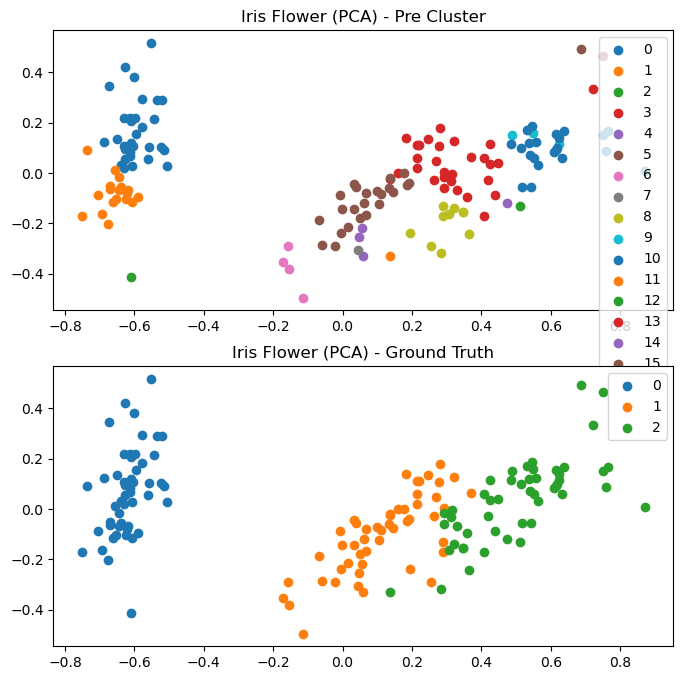

In [333]:
pca = PCA(n_components=2).fit(X)
X_r = pca.transform(X)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
for i in np.unique(indices):
    t = X_r[indices == i]
    plt.scatter(t[:,0], t[:,1], label=i)
plt.legend()
plt.title("Iris Flower (PCA) - Pre Cluster")

plt.subplot(2, 1, 2)
for i in np.unique(y):
    t = X_r[y == i]
    plt.scatter(t[:,0], t[:,1], label=i)
plt.legend()
plt.title("Iris Flower (PCA) - Ground Truth")

In [356]:
def compute_cluster_center_mapping(names, X, y):
    data = np.column_stack((names, X, y))
    df = pd.DataFrame(data, columns=["cluster", "x1", "x2", "x3", "x4", "y"])
    df["cluster"] = df["cluster"].astype(int)

    df1 = df.groupby(by=["cluster"])[["x1", "x2", "x3", "x4"]].mean().sort_index()
    df2 = df.groupby(by=["cluster"])["y"].agg(pd.Series.mode).sort_index()

    mapper = np.unique(names)
    mapper.sort()
    mapper = {x: i for i, x in enumerate(mapper)}
    names = [mapper[x] for x in names]
    return df1.to_numpy(), df2.to_numpy(), names

In [357]:
cluster_centers, cluster_mapping, new_clusters = compute_cluster_center_mapping(indices, X, y)

In [336]:
print(f"Shape of Cluster Centers: {cluster_centers.shape}")

Shape of Cluster Centers: (16, 4)


### Train Piecemeal

In [337]:
def compute_decay(step, N):
    return 1 - (step / N)

def compute_radii(W):
    dmatrix = sch.distance.pdist(W, metric="euclidean")
    smatrix = sch.distance.pdist(W, metric="cosine")
    radius_d = (max(dmatrix) - min(dmatrix)) / 2
    radius_s = (max(smatrix) - min(smatrix)) / 2
    return radius_d, radius_s

def unit_distances(x, W):
    x = x.reshape(1, -1)
    W = W.copy()
    d = np.sqrt(np.sum((x - W)**2, axis=1))
    x = x / np.linalg.norm(x, axis=1)
    W = W.T / np.linalg.norm(W, axis=1)
    ### Same method as pdist
    s = 1 - x.dot(W)
    return d, s.reshape(-1)

def train_som(X, W, N, alpha_0):
    """This is the modifed version of training Self-organizing map
    Args:
    - X: input data shape (m, n)
    - W: weight matrix, in piecemeal, the weight matrix is the cluster centers
    - alpha_0: learning rate
    - N: number of iterations
    """
    W = W.copy()
    n_neurals = len(W)
    n_samples = len(X)
    print(f"Number of neurals: {n_neurals}")
    rd_0, rs_0 = compute_radii(W)
    for step in range(N):
        rd = rd_0 * compute_decay(step, N)
        rs = rs_0 * compute_decay(step, N)
        alpha = alpha_0 * compute_decay(step, N)

        x = X[np.random.choice(n_samples)]
        ud, us = unit_distances(x, W)
        for i, (cd, cs) in enumerate(zip(ud, us)):
            if cd < rd and cs < rs:
                i_d = np.exp((-cd**2) / (2*rd**2))
                i_s = np.exp((-cs**2) / (2*rs**2))
                influence = np.sqrt(i_d * i_s)
                W[i] += alpha * influence * (x - W[i])
    return W

In [338]:
cluster_centers = train_som(X, cluster_centers, 10000, 0.001)

Number of neurals: 16


### Post Merging

In [339]:
def count_element(clusters, c):
    return sum(c == x for x in clusters)

def calculate_min_inter_distance(X, centers, clusters, diff_factor, ignores=[]):
    dmatrix = sch.distance.pdist(centers, metric="euclidean")
    smatrix = sch.distance.pdist(centers, metric="cosine")
    optimal_pair = []
    min_dist = 999999

    for i, x in enumerate(X):
        c = clusters[i]
        if c in ignores:
            continue
        
        n_i = count_element(clusters, c)
        xd, xs = unit_distances(x, centers)
        xd = xd / max(dmatrix)
        xs = xs / max(smatrix)
        xd[c] = 0
        xs[c] = 0
        for j in range(len(xd)):
            if c == j or j in ignores: # Skip if they are in the same cluster
                continue

            n_j = count_element(clusters, j)
            fd = 1 + xd[j] / diff_factor
            fs = 1 + xs[j]
            fn = 1 + np.sqrt(n_i) + np.sqrt(n_j)

            # print(fd, fs, fn)

            dist = fd * fs * fn
            if dist < min_dist:
                min_dist = dist
                optimal_pair = [c, j]
                
    return optimal_pair, min_dist

In [340]:
def max_min_dist(X, clusters):
    total = 0
    n = len(np.unique(clusters))
    for x in np.unique(clusters):
        t = X[clusters == x]
        if len(t) == 0:
            continue
        r = sch.distance.pdist(t, metric="euclidean")
        if len(r) == 0:
            continue

        a = max(r)
        b = min(r)
        
        if b == 0:
            continue
        # print(a, b)
        total += a / b
    return total / n

In [364]:
indices, diff_factor = pre_clustering(X, cut_off)
print(f"Number of clusters: {len(np.unique(indices))}")
cluster_centers, cluster_mapping, assign_clusters = compute_cluster_center_mapping(indices, X, y)
cluster_centers = train_som(X, cluster_centers, 10000, 0.001)

Cutoff: 0.083
Diff factor: 1.019278399795178
Distance threshold: 0.083
Orient threshold: 0.08460010718299978
TDS: 0.11851657325190874
0.0 1.3182333510738444
Number of clusters: 16
Number of neurals: 16


In [365]:
def compute_accuracy(indices, cluster_mapping, y):
    acc = 0
    for i, j in enumerate(indices):
        check = cluster_mapping[j]
        acc += check == y[i]
    return acc / len(y)

Text(0.5, 1.0, 'Iris Flower (PCA) - Ground Truth')

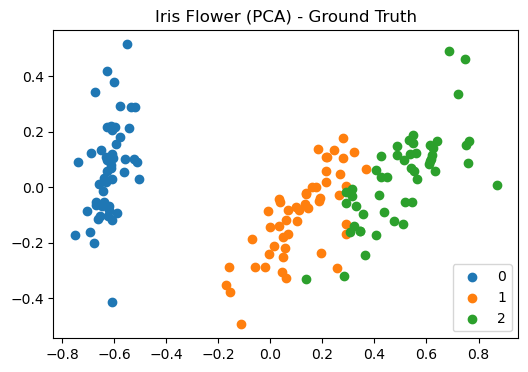

In [361]:
pca = PCA(n_components=2).fit(X)
X_r = pca.transform(X)

1 7.281366127097442 0.88
2 7.801463707604403 0.8733333333333333
3 8.401576300497048 0.8666666666666667
4 9.101707658871803 0.86
5 10.048239215241496 0.8466666666666667
6 10.820406365869134 0.8266666666666667
7 11.825099600918975 0.8066666666666666
8 12.728079588439948 0.78
9 14.546376672502799 0.7733333333333333
10 16.970772784586597 0.7733333333333333
11 18.693452558060137 0.7
12 20.402605704778807 [0.55333333 0.55333333]
13 22.975228591328147 0.5533333333333333
14 9.091511244127553 [0.54 0.54]


ValueError: num must be an integer with 1 <= num <= 14, not 15

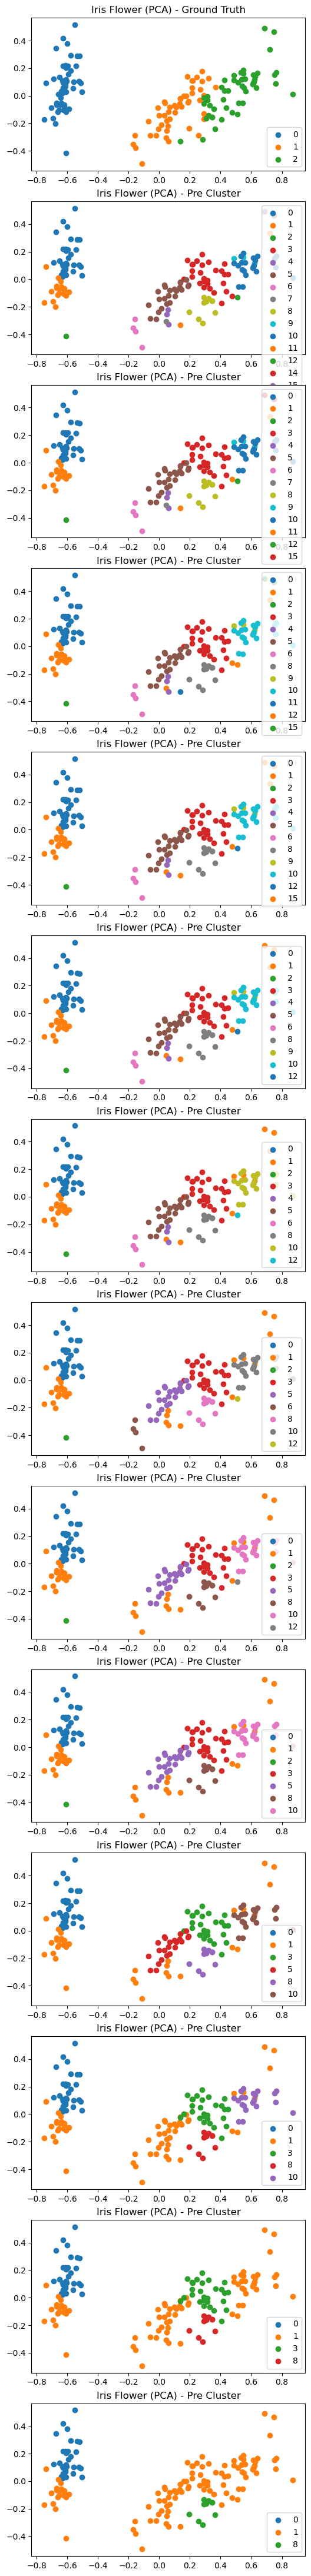

In [367]:
ignores = []
evals = []
best = [0, 0, []]
new_clusters = assign_clusters.copy()
size = len(np.unique(new_clusters)) - 2
plt.figure(figsize=(6, 4*size))
plt.subplot(size, 1, 1)
for i in np.unique(y):
    t = X_r[y == i]
    plt.scatter(t[:,0], t[:,1], label=i)
plt.legend()
plt.title("Iris Flower (PCA) - Ground Truth")

for i in range(1, len(np.unique(new_clusters)) - 1):
    pair, dist = calculate_min_inter_distance(X, cluster_centers, new_clusters, diff_factor, ignores)
    new_clusters, new_center = merge_cluster(new_clusters, pair[0], pair[1], X)
    cluster_centers[pair[0]] = new_center
    ignores.append(pair[1])
    _, b, a = compute_cluster_center_mapping(new_clusters, X, y)
    metric = max_min_dist(X, new_clusters)
    print(i, metric, compute_accuracy(a, b, y))
    
    if best[1] <= metric:
        best[0] = i
        best[1] = metric
        best[2] = new_clusters.copy()

    plt.subplot(size, 1, i + 1)
    for i in np.unique(new_clusters):
        t = X_r[new_clusters == i]
        plt.scatter(t[:,0], t[:,1], label=i)
    plt.legend()
    plt.title("Iris Flower (PCA) - Pre Cluster")
    track = (i, metric)
    evals.append(track)

Text(0.5, 1.0, 'The average max-min Euclidean distance ratio')

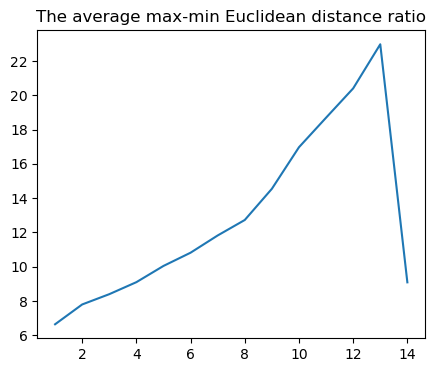

In [346]:
plt.figure(figsize=(5, 4))
plt.plot([x for (x, _) in evals], [y for (_, y) in evals])
plt.title("The average max-min Euclidean distance ratio")

In [352]:
indices = standardize_cluster_index(best[2])

In [353]:
label_mapper = extract_mapper(indices, y)
compute_accuracy(indices, label_mapper, y)

0.5533333333333333

Text(0.5, 1.0, 'Iris Flower (PCA) - Ground Truth')

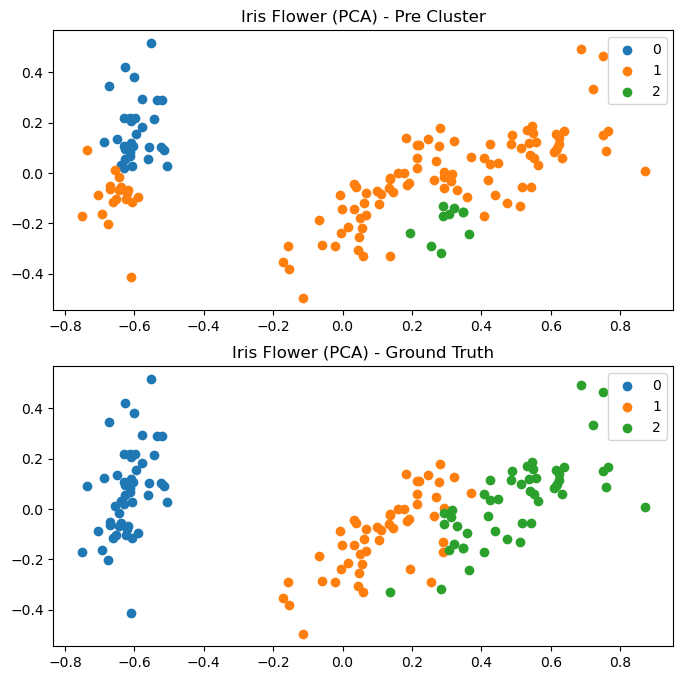

In [354]:
pca = PCA(n_components=2).fit(X)
X_r = pca.transform(X)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
for i in np.unique(indices):
    t = X_r[indices == i]
    plt.scatter(t[:,0], t[:,1], label=i)
plt.legend()
plt.title("Iris Flower (PCA) - Pre Cluster")

plt.subplot(2, 1, 2)
for i in np.unique(y):
    t = X_r[y == i]
    plt.scatter(t[:,0], t[:,1], label=i)
plt.legend()
plt.title("Iris Flower (PCA) - Ground Truth")